In [ ]:
from glob import glob
from nilearn import masking, maskers, regions
from nilearn.image import load_img
from nimare.stats import pearson
from sklearn.preprocessing import MinMaxScaler
from nxviz.utils import node_table
import pickle
import pandas as pd
import numpy as np
import os
import os.path as osp
import panel as pn
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
from utils.basics import PRJ_DIR
pn.extension()
from nimare.dataset import Dataset
import hvplot.pandas
from scipy.stats import pearsonr, spearmanr
import holoviews as hv

In [2]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 43194


In [3]:
import networkx as nx
from nxviz.utils import node_table

In [4]:
def create_unimodal_graph_from_matrix(data):
    assert isinstance(data,pd.DataFrame),    "++ERROR [plot_as_graph]:  input data expected to be a pandas dataframe"
    assert 'ROI_ID'     in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named ROI_ID"
    assert 'Hemisphere' in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Hemisphere"
    assert 'Network'    in data.index.names, "++ERROR [plot_as_graph]:  input data expected to have one column named Network"
    assert 'RGB'    in data.index.names,     "++ERROR [plot_as_graph]: input data expected to have one column named RGB"
    
    # Convert input to ints (this function only works for unweigthed graphs)
    fdata          = data.copy().astype('int')
    fdata.index    = fdata.index.get_level_values('ROI_ID')
    fdata.columns  = fdata.index
    
    # Create basic Graph
    # ==================
    G = nx.from_pandas_adjacency(fdata)
    
    # Add information about hemisphere and network
    # ============================================
    hemi_attribs      = {row['ROI_ID']:row['Hemisphere'] for r,row in roi_info.iterrows()}
    nw_attribs        = {row['ROI_ID']:row['Network'] for r,row in roi_info.iterrows()}
    lab_attribs       = {row['ROI_ID']:row['ROI_Name'] for r,row in roi_info.iterrows()}
    col_attribs       = {row['ROI_ID']:row['RGB'] for r,row in roi_info.iterrows()}
    id_attribs        = {row['ROI_ID']:row['ROI_ID'] for r,row in roi_info.iterrows()}
    deg_attribs          = nx.degree_centrality(G)
    degree_centr_attribs = {r:v for r,v in zip(list(deg_attribs.keys()), MinMaxScaler(feature_range=(0.001,0.01)).fit_transform(np.array(list(nx.degree_centrality(G).values())).reshape(-1,1)).flatten())}
    degree_attribs       = dict(G.degree())
    nx.set_node_attributes(G,hemi_attribs,'Hemisphere')
    nx.set_node_attributes(G,nw_attribs,'Network')
    nx.set_node_attributes(G,lab_attribs,'ROI_Name')
    nx.set_node_attributes(G,id_attribs,'ROI_ID')
    nx.set_node_attributes(G,col_attribs,'RGB')
    nx.set_node_attributes(G,degree_centr_attribs,'Degree_Centrality')
    nx.set_node_attributes(G,degree_attribs,'Degree')
    nx.set_node_attributes(G,nx.eigenvector_centrality(G),'Eigenvector_Centrality')
    nx.set_node_attributes(G,nx.pagerank(G),'Page_Rank')

    # Add edge attributes based on which model they represent
    # =======================================================
    # Count the input values
    val_counts = pd.Series(fdata.values.flatten()).value_counts()
    # Check for the presence of positive edges
    if 1 in val_counts.index:
        #fdata_pos will have 1s for edges in positive model, zero anywhere else
        fdata_pos              = fdata.copy()
        fdata_pos[fdata_pos<0] = 0 # Removing -1 from positive graph
        G_pos = nx.from_pandas_adjacency(fdata_pos)
    model_attribs = {}
    if G_pos is not None:
        for edge in G_pos.edges:
            model_attribs[edge] = 'pos'
    nx.set_edge_attributes(G,model_attribs,'Model')
    
    return G

In [5]:
def extract_topic_id_from_topic_label(topic_label):
    return int((topic.split('__')[1]).split('_')[0])

# 1. Load NBS results

## 1.1. Load ROI Information

In [6]:
from utils.basics import ATLASES_DIR, FB_400ROI_ATLAS_NAME
ATLAS_NAME = FB_400ROI_ATLAS_NAME
SOLUTION   = 'CL02_0p001'
vocab      = 'LDA50'

In [7]:
print('++ INFO: Atlas is %s' % ATLAS_NAME)

++ INFO: Atlas is Schaefer2018_400Parcels_7Networks_AAL2


In [8]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)
roi_info.head(5)

,ROI_ID,Hemisphere,Network,ROI_Name,pos_R,pos_A,pos_S,color_R,color_G,color_B,RGB
0,1,LH,Vis,LH_Vis_1,-32,-42,-20,120,17,128,#781180
1,2,LH,Vis,LH_Vis_2,-30,-32,-18,120,17,129,#781181
2,3,LH,Vis,LH_Vis_3,-36,-62,-16,120,17,130,#781182
3,4,LH,Vis,LH_Vis_4,-24,-54,-8,120,17,131,#781183
4,5,LH,Vis,LH_Vis_5,-24,-72,-10,120,17,132,#781184


In [9]:
networks = list(roi_info['Network'].unique())
print(networks)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical']


## 1.2. Load Connections Significantly stronger for F1 > F2 contrast

In [10]:
data_f1GTf2 = np.loadtxt('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_{s}_Results/NBS_{s}_F1gtF2.edge'.format(s=SOLUTION, ATLAS_NAME=ATLAS_NAME))
print('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_{s}_Results/NBS_{s}_F1gtF2.edge'.format(s=SOLUTION, ATLAS_NAME=ATLAS_NAME))
data_f1GTf2 = pd.DataFrame(data_f1GTf2,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_0p001_Results/NBS_CL02_0p001_F1gtF2.edge


## 1.2. Load Connections Significantly stronger for F2 > F1 contrast

In [11]:
data_f2GTf1 = np.loadtxt('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_{s}_Results/NBS_{s}_F2gtF1.edge'.format(s=SOLUTION, ATLAS_NAME=ATLAS_NAME))
print('/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_{s}_Results/NBS_{s}_F2gtF1.edge'.format(s=SOLUTION, ATLAS_NAME=ATLAS_NAME))
data_f2GTf1 = pd.DataFrame(data_f2GTf1,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_0p001_Results/NBS_CL02_0p001_F2gtF1.edge


***
# 2. Setup Decoding

Set folders of interest

In [12]:
RESOURCE_NIMARE_DIR  = osp.join(PRJ_DIR,'nimare')
VOCAB_DIR            = osp.join(RESOURCE_NIMARE_DIR,vocab)
METAMAPS_RPI_DIR     = osp.join(VOCAB_DIR,"meta-analyses-RPI")  # where to save meta-analysis maps

Set decoding mask and the parcellation file

In [13]:
nimare_decoding_mask_path = osp.join(RESOURCE_NIMARE_DIR,'NiMare_Decoding_Mask_GMribbon_2023.nii.gz')
atlas_mask_path           = osp.join(RESOURCE_NIMARE_DIR,f'{ATLAS_NAME}_Decoding_Template.nii.gz')

Gather the location of the decoding file (i.e., z-desc-specificity) for all topics of interest.

## 2.1. Final Topic List

Also create a list with the topic names (this will still include spaces)

In [14]:
lda_model_path = f'/data/SFIMJGC_Introspec/prj2021_dyneusr/Resources_NiMare/{vocab}/lda_model.pkl.gz'
with open(lda_model_path,'rb') as f:
    model_results = pickle.load(f)
model = model_results['model']
dset  = model_results['new_dset']

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


We start with the name of all topics in the dictionary

In [16]:
TOPIC_MODEL = 'LDA'
if TOPIC_MODEL == 'NS':
    # Get the meta-analytic files and their names
    topic_files = sorted(glob(os.path.join(METAMAPS_RPI_DIR, f"{vocab}_abstract_*_z_desc-specificity.nii.gz")))
    TOPIC_LIST  = [os.path.basename(filename).split("_z")[0] for filename in topic_files]
    print(TOPIC_LIST)
else:
    # Get the meta-analytic files and their names
    topic_files = sorted(glob(os.path.join(METAMAPS_RPI_DIR, f"{vocab}__*_z_desc-specificity.nii.gz")))
    TOPIC_LIST  = [os.path.basename(filename).split("_z")[0] for filename in topic_files]
    print(TOPIC_LIST)

['LDA50__10_language_semantic_word', 'LDA50__11_adults_age_older', 'LDA50__12_motion_mt_biological', 'LDA50__13_memory_encoding_retrieval', 'LDA50__14_motor_cortex_movement', 'LDA50__15_number_model_reasoning', 'LDA50__16_speech_auditory_temporal', 'LDA50__17_task_prefrontal_cortex', 'LDA50__18_gaze_awareness_eyes', 'LDA50__19_eye_functional_target', 'LDA50__1_adhd_pd_task', 'LDA50__20_cognitive_controls_disease', 'LDA50__21_attention_task_wm', 'LDA50__22_pitch_rate_musicians', 'LDA50__23_emotional_amygdala_emotion', 'LDA50__24_social_social-cognition_cognition', 'LDA50__25_reward_striatum_ventral', 'LDA50__26_visual_object_objects', 'LDA50__27_connectivity_functional_network', 'LDA50__28_action_parietal_cortex', 'LDA50__29_fear_ptsd_threat', 'LDA50__2_functional_hallucinations_deception', 'LDA50__30_schizophrenia_matter_volume', 'LDA50__31_face_faces_recognition', 'LDA50__32_decision_making_decision-making', 'LDA50__33_et_al_et-al', 'LDA50__34_task_training_performance', 'LDA50__35_re

Many topics have very sparse meta-activation maps becuase only a handful of studies contributed to them. To eliminate those, we will focus only on topics with 500 or more studies

In [17]:
df = df = pd.DataFrame(index=TOPIC_LIST,columns=['#Studies'])
for topic in TOPIC_LIST:
    topic_space = topic.replace('-',' ')
    df.loc[topic,'#Studies'] = len(dset.get_studies_by_label(topic_space))

In [18]:
MIN_NUMBER_STUDIES = 500

In [19]:
df.sort_values(by='#Studies').hvplot.hist(bins=1000,width=2500) * hv.VLine(MIN_NUMBER_STUDIES)

:Overlay
   .Histogram.I :Histogram   [#Studies]   (#Studies_count)
   .VLine.I     :VLine   [x,y]

In [20]:
TOPIC_LIST = df[df['#Studies']>=MIN_NUMBER_STUDIES].sort_values(by='#Studies').index

In [21]:
print(len(TOPIC_LIST))

50


## 2.1. Load Reverse Inference Maps for all topics into memory as np.arrays

In [22]:
%%time
topic_maps = {}             # Create empty dictionary that will hold all the maps
for topic in TOPIC_LIST: 
    path = osp.join(METAMAPS_RPI_DIR,f'{topic}_z_desc-specificity.nii.gz') # Compose path to topic map
    topic_maps[topic] = load_img(path).get_fdata() # Load into memory using nibabel
print('++ INFO: Topic Map Dimensions = %s' % str(topic_maps[TOPIC_LIST[0]].shape))
print('++ INFO: Number of Topic Maps loaded into the dictionary: %d maps' % len(topic_maps))

++ INFO: Topic Map Dimensions = (72, 95, 79)
++ INFO: Number of Topic Maps loaded into the dictionary: 50 maps
CPU times: user 1.7 s, sys: 137 ms, total: 1.84 s
Wall time: 2.07 s


## 2.2. Load Atlas into memory

We will use this to extract voxels per ROI so that we can then obtain average values from the decoding maps

In [23]:
atlas = load_img(atlas_mask_path).get_fdata()
atlas = atlas.astype(int)
n_rois = int(atlas.max())
print('++ INFO: Atlas Dimensions = %s' % str(atlas.shape))
print('++ INFO: Number of ROIs: %s' % n_rois)

++ INFO: Atlas Dimensions = (72, 95, 79)
++ INFO: Number of ROIs: 380


In [24]:
assert atlas.shape == topic_maps[TOPIC_LIST[0]].shape, '++ ERROR: Atlas and Decoding maps do not have the same size'

We will also load the atlas as a vector. This will come handy when trying to write Network Metric summary maps into nii files 

In [25]:
atlas_vector = masking.apply_mask(atlas_mask_path, nimare_decoding_mask_path)
print('++ INFO: Atlas Dimensions as a vector = %s' % str(atlas_vector.shape))

++ INFO: Atlas Dimensions as a vector = (119303,)


## 2.3. Create ROI-level Decoding Vectors

Each topic is associated with a voxel-wise spatial map of "activation". Our network summary metrics are only available at the ROI level (i.e., one value per region). As such, it does nto feel fair to compute voxel-wise correlations (e.g., common Neurosynth decoding), but to compute correlations at the ROI level. To do so, we first need to transform the decoding maps into vectors that will contain the ROI average values.

In [26]:
%%time
topic_maps_roiview_df = pd.DataFrame(columns=TOPIC_LIST,
                                     index=roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
topic_maps_roiview_df.columns.name = 'Topic'
for topic in TOPIC_LIST:
    for hm,nw,roi_name,roi_id,rgb in topic_maps_roiview_df.index:
        this_topic_vals = topic_maps[topic][atlas==roi_id]
        this_topic_vals[this_topic_vals<0] = np.nan
        # At least 50% of voxels must be positive for an ROI to be assigned a mean value
        # ==============================================================================
        if np.isnan(this_topic_vals).sum() <= 0.75 * this_topic_vals.shape[0]: 
            topic_maps_roiview_df.loc[(hm,nw,roi_name,roi_id,rgb),topic] = np.nanmean(this_topic_vals)
        else:
            topic_maps_roiview_df.loc[(hm,nw,roi_name,roi_id,rgb),topic] = np.nan
        #this_topic_vals = this_topic_vals[this_topic_vals>0] #ONLY POSITIVE VALUES (as NW are only positive)
        #topic_maps_roiview_df.loc[(hm,nw,roi_name,roi_id,rgb),topic] = this_topic_vals.mean()
topic_maps_roiview_df = topic_maps_roiview_df.infer_objects()

CPU times: user 16.8 s, sys: 53.7 ms, total: 16.9 s
Wall time: 16.9 s


In [27]:
topic_maps_roiview_df.reset_index(drop=True).hvplot.heatmap(cmap='Reds', width=2200, height=800).opts(xrotation=90)

:HeatMap   [columns,index]   (value)

***
# 3. Transform Network Models into summary ROI maps using differnet network metrics

Create a dictionary with all the network models that will try to decode

In [28]:
inputs={'f1GTf2':data_f1GTf2,'f2GTf1':data_f2GTf1}

## 3.1. Create a Graph from the model, compute summary metrics and save as a dataframe

In [29]:
%%time
G,G_att = {},{}
for contrast in inputs.keys():
    # Create Graph Model
    G[contrast]      = create_unimodal_graph_from_matrix(inputs[contrast])
    # Extract Node Table from Graph Model (will now contain the Network Metrics)
    G_att[contrast]  = node_table(G[contrast])
    G_att[contrast]  = G_att[contrast].set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).sort_index(level='ROI_ID')
N_rois = G_att[contrast].shape[0]

CPU times: user 196 ms, sys: 3.98 ms, total: 200 ms
Wall time: 200 ms


In [30]:
G_att[contrast].head(3)

Degree_Centrality  Degree  \
Hemisphere Network ROI_Name ROI_ID RGB                                  
LH         Vis     LH_Vis_1 1      #781180           0.004436      21   
                   LH_Vis_2 2      #781181           0.002309       8   
                   LH_Vis_3 3      #781182           0.001818       5   

                                            Eigenvector_Centrality  Page_Rank  
Hemisphere Network ROI_Name ROI_ID RGB                                         
LH         Vis     LH_Vis_1 1      #781180                0.164645   0.009331  
                   LH_Vis_2 2      #781181                0.082559   0.003557  
                   LH_Vis_3 3      #781182                0.048350   0.002350

## 3.2. Write to disk ROI-level maps of the summary metrics for all models

In [31]:
%%time
for contrast in inputs.keys():
    for metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        # Create Empty Vector with same dimensions as atlas
        output_vector = np.zeros(atlas_vector.shape)
        # For each ROI extract the Graph Metric of interest
        for hm,nw,roi_name,roi_id,rgb in G_att[contrast].index:
            output_vector[atlas_vector==roi_id] = G_att[contrast].loc[(hm,nw,roi_name,roi_id,rgb),metric]
        # Write to disk just in case we want to look at it later
        output_img = masking.unmask(output_vector,nimare_decoding_mask_path)
        output_path = osp.join(RESOURCE_NIMARE_DIR,f'{contrast}_{metric}.nii')
        output_img.to_filename(output_path)
        print('++ INFO: File written to disk [%s]' % output_path)

++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f1GTf2_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f1GTf2_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f1GTf2_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f2GTf1_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f2GTf1_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/f2GTf1_Page_Rank.nii]
CPU times: user 1.62 s, sys: 57 ms, total: 1.68 s
Wall time: 1.76 s


## 3.3. Decode (i.e., compute correlation between ROI summary nw metrics and ROI summary values from topic maps)

In [32]:
decoding_results = {}
non_zero_rois_selector = {}
for contrast in ['f1GTf2','f2GTf1']:
    for nw_metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        decoding_results[(contrast,nw_metric)] = pd.DataFrame(index=TOPIC_LIST, columns=['pearson','pearson_p','spearman','spearman_p'])
        non_zero_rois_selector[contrast] = (G_att[contrast]['Degree']>0)
        num_non_zero_roi = non_zero_rois_selector[contrast].sum()
        print(contrast, nw_metric, num_non_zero_roi, end='-->')
        num_bad_topics = 0
        for topic in TOPIC_LIST:
            ns_input = topic_maps_roiview_df[topic][non_zero_rois_selector[contrast]]
            gr_input = G_att[contrast][nw_metric][non_zero_rois_selector[contrast]]
            # Extra stuff to account for ROIs with all zeros in NS (most likely becuase of negative weights)
            aux = pd.concat([ns_input,gr_input],axis=1).dropna()
            ns_input = aux[topic]
            gr_input = aux[nw_metric]
            # Decode
            if aux.shape[0] >= 50:
                decoding_results[(contrast,nw_metric)].loc[topic,'pearson'], decoding_results[(contrast,nw_metric)].loc[topic,'pearson_p']   = pearsonr(ns_input,gr_input, alternative='two-sided')
                decoding_results[(contrast,nw_metric)].loc[topic,'spearman'], decoding_results[(contrast,nw_metric)].loc[topic,'spearman_p'] = spearmanr(ns_input,gr_input, alternative='two-sided')
            else:
                print(topic,end=',')
                num_bad_topics += 1
                decoding_results[(contrast,nw_metric)].loc[topic,'pearson'], decoding_results[(contrast,nw_metric)].loc[topic,'pearson_p']   = 0,1
                decoding_results[(contrast,nw_metric)].loc[topic,'spearman'], decoding_results[(contrast,nw_metric)].loc[topic,'spearman_p'] = 0,1
        print(num_bad_topics,' ')

f1GTf2 Degree 173-->LDA50__6_depression_mdd_treatment,LDA50__44_eeg_frequency_white,LDA50__20_cognitive_controls_disease,LDA50__43_effects_women_expressions,LDA50__30_schizophrenia_matter_volume,LDA50__3_bold_signal_level,6  
f1GTf2 Eigenvector_Centrality 173-->LDA50__6_depression_mdd_treatment,LDA50__44_eeg_frequency_white,LDA50__20_cognitive_controls_disease,LDA50__43_effects_women_expressions,LDA50__30_schizophrenia_matter_volume,LDA50__3_bold_signal_level,6  
f1GTf2 Page_Rank 173-->LDA50__6_depression_mdd_treatment,LDA50__44_eeg_frequency_white,LDA50__20_cognitive_controls_disease,LDA50__43_effects_women_expressions,LDA50__30_schizophrenia_matter_volume,LDA50__3_bold_signal_level,6  
f2GTf1 Degree 300-->LDA50__6_depression_mdd_treatment,LDA50__44_eeg_frequency_white,LDA50__43_effects_women_expressions,LDA50__30_schizophrenia_matter_volume,4  
f2GTf1 Eigenvector_Centrality 300-->LDA50__6_depression_mdd_treatment,LDA50__44_eeg_frequency_white,LDA50__43_effects_women_expressions,LDA50

***
# 4. Show Results

In [33]:
DECODING_METRIC = 'pearson'

In [34]:
SUMM_METRIC = 'Degree'

## 4.1. Plot Decoding Results for all topics

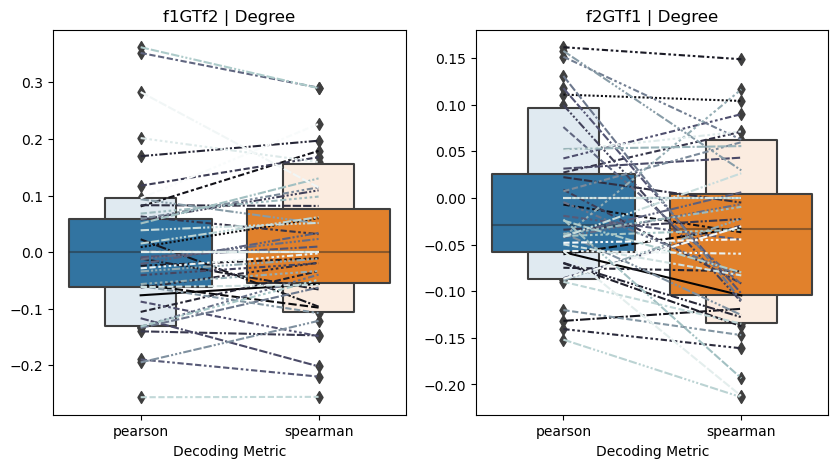

In [35]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for i,contrast in enumerate(inputs.keys()):
    sns.boxenplot(data=decoding_results[contrast,SUMM_METRIC][['pearson','spearman']],ax=axs[i])
    sns.lineplot(data=decoding_results[contrast,SUMM_METRIC][['pearson','spearman']].T, legend=False, ax=axs[i], palette='bone')
    axs[i].set_title(contrast+' | '+SUMM_METRIC)
    axs[i].set_xlabel('Decoding Metric')

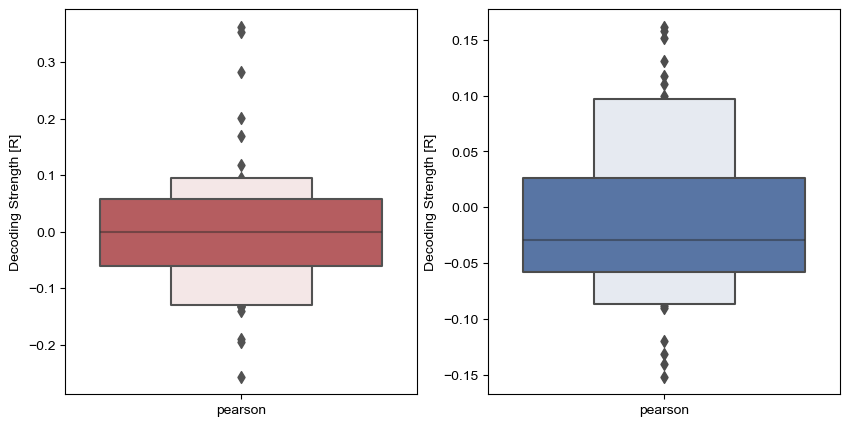

In [36]:
fig,ax = fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.set(style='white')
for i,(contrast,color) in enumerate(zip(inputs.keys(),['r','b'])):
    aux = pd.DataFrame(decoding_results[contrast,SUMM_METRIC][DECODING_METRIC]).reset_index(drop=True)
    sns.boxenplot(aux, color=color, ax=ax[i])
    ax[i].set_ylabel('Decoding Strength [R]')

## 4.2. Select Top Topics

In [37]:
top_topics = {contrast:decoding_results[(contrast,SUMM_METRIC)][(decoding_results[(contrast,SUMM_METRIC)][DECODING_METRIC+'_p']<0.05) & (decoding_results[(contrast,SUMM_METRIC)][DECODING_METRIC]>0)].sort_values(by=DECODING_METRIC, ascending=False)
              for contrast in inputs.keys()}

In [38]:
pn.Row(pn.pane.DataFrame(top_topics['f1GTf2'], width=1000), 
       pn.pane.DataFrame(top_topics['f2GTf1'], width=1000))

Row
    [0] DataFrame(DataFrame, width=1000)
    [1] DataFrame(DataFrame, width=1000)

## 4.3. Load LDA Model: word and topic distributions

In [39]:
lda_stop_words = ['rs','gm']+ [w for w in model.distributions_['p_topic_g_word_df'].columns if 'cortex' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'functional' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'mri' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'blood' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'medial' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'lateral' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'posterior' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'anterior' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'ventral' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'dorsal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'temporal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'occipital' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'parietal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'frontal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '0' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '1' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '2' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '3' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '4' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '5' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '6' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '7' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '8' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if '9' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'atlas' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'aal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'acc' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'magnetic' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'resonance' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'bold' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'connectivity' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'signal' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'response' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'responses' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'level' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'network' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'using' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'dmn' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'pet' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'default' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'default mode' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'amygdala' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'cingulate' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'task' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'involved' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'resting' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'state' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'resting state' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'cortical' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'fc' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'ica' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'seed' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'stimuli' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'non' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'intrinsic' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'rest' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'mpfc' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'mode' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'pcc' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'emission' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'tomography' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'independent component' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'correlation' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'correlated' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'positron' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'processes' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'component' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'gm' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'volume' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'connections' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'gm volume' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'rule' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'insula' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'higher' in w] + \
             [w for w in model.distributions_['p_topic_g_word_df'].columns if 'cbf' in w]

stop_words = lda_stop_words + list(STOPWORDS)


In [40]:
lda_all_words  = list(model.distributions_['p_topic_g_word_df'].columns)
lda_good_words = [w for w in lda_all_words if w not in lda_stop_words]
print(len(lda_good_words))

131375


In [41]:
brain_mask = np.array(Image.open("/data/SFIMJGC_Introspec/2023_fc_introspection/Brain_300.png"))
brain_mask = brain_mask > 100
brain_mask = 255 * brain_mask.astype(int)

In [95]:
if TOPIC_MODEL != 'NS':
    words_in_contrast_freq_dict = {}
    for contrast in inputs.keys():
        dff = pd.DataFrame()
        for topic in top_topics[contrast].index:
            topic_space      = topic.replace('-',' ')
            this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
            term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
            top_words_series      = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:41].rank() * this_topic_r
            for w in top_words_series.index:
                dff.loc[topic,w] = top_words_series[w]
        words_in_contrast_freq_dict[contrast] = dff.sum().sort_values(ascending=False)[0:40].rank()
else:
    # Load Words per Topic
    path = '/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/LDA50/neurosynth/data-neurosynth_version-7_vocab-LDA50_keys.tsv'
    words_per_topic = pd.read_csv(path, sep='\t', header=None)
    # Load Original Dataset to get Topic IDs in order
    dset = Dataset.load('/data/SFIMJGC_Introspec/2023_fc_introspection/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz')
    # Create Dictionary with weights for each top 40 words per topic
    term_weights_per_topic = {}
    for topic_idx,topic in enumerate(dset.get_labels()):
        this_topic_words = words_per_topic.loc[topic_idx][2]
        this_topic_words_top40 = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}
    # Create Final Frequency counts per Topic (for WC)
    words_in_contrast_freq_dict = {}
    for contrast in inputs.keys():
        dff = pd.DataFrame()
        for topic in top_topics[contrast].index:
            topic_space      = topic.replace('-',' ')
            this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
            for word,weight in term_weights_per_topic[topic].items():
                dff.loc[topic,word] = weight
        words_in_contrast_freq_dict[contrast] = dff.sum().rank()

/tmp/ipykernel_7459/205977954.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dff.loc[topic,w] = top_words_series[w]
/tmp/ipykernel_7459/205977954.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dff.loc[topic,w] = top_words_series[w]
/tmp/ipykernel_7459/205977954.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

In [171]:
brain_mask = np.array(Image.open("/data/SFIMJGC_Introspec/2023_fc_introspection/Brain_Sag.png"))
brain_mask = brain_mask > 100
brain_mask = 255 * brain_mask.astype(int)

In [175]:
wc = {}
for contrast,cmap in zip(inputs.keys(),['Reds','Blues']):
    wc[contrast] = WordCloud(max_font_size=40,min_font_size=9, mask=brain_mask,
                   contour_color='black', contour_width=3,  #max_words=30,
                   background_color='white', colormap=cmap,
                   repeat=False).generate_from_frequencies(words_in_contrast_freq_dict[contrast])

In [176]:
top_topics['f1GTf2']['pearson']

Topic
LDA50__42_self_cortex_mpfc                     0.362156
LDA50__24_social_social-cognition_cognition    0.352064
LDA50__27_connectivity_functional_network      0.282954
LDA50__23_emotional_amygdala_emotion           0.201588
Name: pearson, dtype: object

(-0.5, 342.5, 279.5, -0.5)

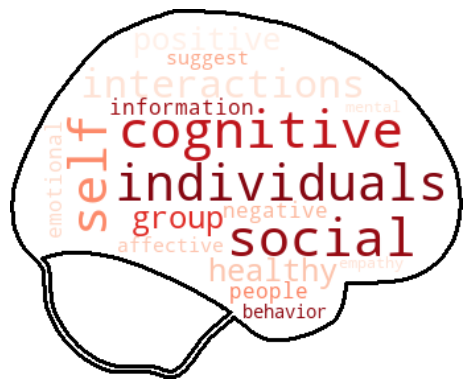

In [177]:
plt.imshow(wc['f1GTf2'],interpolation='bilinear')
plt.axis('off')

In [157]:
top_topics['f2GTf1']['pearson']

Topic
LDA50__5_functional_anterior_navigation    0.161628
LDA50__40_pain_insula_cortex                0.15142
Name: pearson, dtype: object

(-0.5, 399.5, 199.5, -0.5)

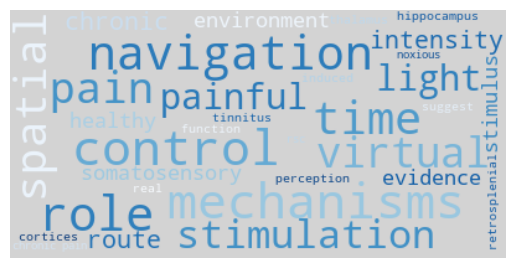

In [154]:
plt.imshow(wc['f2GTf1'],interpolation='bilinear')
plt.axis('off')

In [99]:
words_in_contrast_freq_dict['f1GTf2'].sort_values(ascending=False)[0:40]

cognitive              40.0
social                 39.0
self                   38.0
individuals            37.0
interactions           36.0
positive               35.0
healthy                34.0
group                  33.0
information            32.0
people                 31.0
negative               30.0
emotional              29.0
suggest                28.0
affective              27.0
behavior               26.0
empathy                25.0
mental                 24.0
social cognition       23.0
correlates             22.0
mind                   21.0
cognition              20.0
person                 19.0
moral                  18.0
sexual                 17.0
tom                    16.0
interaction            15.0
referential            14.0
human                  13.0
personality            12.0
independent            11.0
self referential       10.0
control                 9.0
social interactions     8.0
traits                  7.0
scale                   6.0
large               

In [67]:
words_in_contrast_freq_dict = {}
for contrast in inputs.keys():
    dff = pd.DataFrame()
    for topic in top_topics[contrast].index:
        topic_space      = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
        top_words_series      = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:21].rank() * this_topic_r
        for w in top_words_series.index:
            dff.loc[topic,w] = top_words_series[w]
    words_in_contrast_freq_dict[contrast] = dff.sum()

['LDA50_abstract_weight__0_network_state_resting',
 'LDA50_abstract_weight__1_anxiety_trait_personality',
 'LDA50_abstract_weight__2_cerebellar_cerebellum_basal',
 'LDA50_abstract_weight__3_cortex_anterior_cingulate',
 'LDA50_abstract_weight__4_stimulus_time_repetition',
 'LDA50_abstract_weight__5_gyrus_frontal_inferior',
 'LDA50_abstract_weight__6_auditory_speech_temporal',
 'LDA50_abstract_weight__7_reward_feedback_striatum',
 'LDA50_abstract_weight__8_mpfc_social_medial',
 'LDA50_abstract_weight__9_memory_working_wm',
 'LDA50_abstract_weight__10_food_taste_weight',
 'LDA50_abstract_weight__11_learning_training_practice',
 'LDA50_abstract_weight__12_women_men_sex',
 'LDA50_abstract_weight__13_fear_threat_smokers',
 'LDA50_abstract_weight__14_disease_ad_pd',
 'LDA50_abstract_weight__15_task_performance_cognitive',
 'LDA50_abstract_weight__16_response_inhibition_control',
 'LDA50_abstract_weight__17_motor_cortex_hand',
 'LDA50_abstract_weight__18_number_ips_numerical',
 'LDA50_abstract

In [41]:
words_in_contrast_freq_dict = {}
for contrast in inputs.keys():
    dff = pd.DataFrame()
    for topic in top_topics[contrast].index:
        topic_space      = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
        top_words_series      = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:21].rank() * this_topic_r
        for w in top_words_series.index:
            dff.loc[topic,w] = top_words_series[w]
    words_in_contrast_freq_dict[contrast] = dff.sum()

KeyError: 'LDA50_abstract_weight__8_mpfc_social_medial'

In [253]:
model.distributions_['p_topic_g_word_df'].loc['LDA50__5_functional_anterior_navigation'].sort_values(ascending=False)[0:20]

functional             260.300719
anterior               164.799722
navigation             137.047058
using                  131.403240
time                   126.629789
magnetic               111.678272
cortex                 103.488873
resonance              101.875491
response               101.439499
magnetic resonance     101.187038
spatial                 97.224852
posterior               96.168122
involved                89.603327
functional magnetic     82.015790
cortical                78.893503
virtual                 76.532411
temporal                74.607502
mechanisms              74.405648
light                   73.112759
higher                  71.947606
Name: LDA50__5_functional_anterior_navigation, dtype: float64

(-0.5, 304.5, 304.5, -0.5)

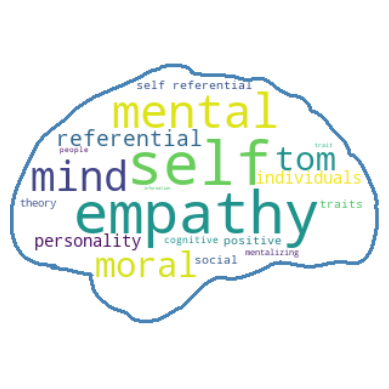

In [239]:
aa= WordCloud(max_font_size=50, 
                   contour_color='steelblue', contour_width=3,  max_words=20,
                   background_color='white',
                   repeat=False, mask=brain_mask).generate_from_frequencies(top_words_series)
plt.imshow(aa,interpolation='bilinear')
plt.axis('off')

In [240]:
top_words_series

self                21.0
empathy             20.0
mental              19.0
mind                18.0
moral               17.0
tom                 16.0
referential         15.0
personality         14.0
individuals         13.0
self referential    12.0
social              11.0
positive            10.0
traits               9.0
theory               8.0
cognitive            7.0
mentalizing          6.0
people               5.0
trait                4.0
information          3.0
person               2.0
affective            1.0
Name: LDA50__42_self_cortex_mpfc, dtype: float64

In [221]:
words_in_contrast_freq_dict = {}
for contrast in inputs.keys():
    dff=pd.DataFrame()
    words_in_contrast_freq_dict[contrast] = {}
    for topic in top_topics[contrast].index:
        topic_space      = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
        top_words_series = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:21]
        for w in top_words_series.index:
            dff.loc[topic,w] = top_words_series[w] * this_topic_r
    words_in_contrast_freq_dict[contrast] = dff.sum() #.rank()

In [222]:
words_in_contrast_freq_dict['f1GTf2'].sort_values(ascending=False)[0:20]

social          1221.020749
self             948.083814
emotional        868.593883
emotion          449.074039
negative         359.983317
cognitive        353.636278
neutral          315.432166
positive         268.620765
affective        240.171785
regulation       184.603023
individuals      180.321194
empathy          161.188501
people           144.512352
information      142.267957
interactions     137.642170
mental           136.554602
mind             135.279044
moral            133.643616
tom              129.021857
emotions         127.323478
dtype: float64

In [223]:
words_in_contrast_freq_dict['f2GTf1'].sort_values(ascending=False)[0:20]

pain             441.390857
stimulation       55.268904
painful           55.268627
intensity         48.740297
control           41.993386
chronic           39.081649
somatosensory     38.566204
mechanisms        35.749453
healthy           35.116553
stimulus          33.826480
perception        33.029311
tinnitus          29.527145
cortices          27.391835
induced           26.749548
thalamus          26.550467
chronic pain      25.590213
noxious           24.984531
placebo           23.411234
anxiety           22.475908
navigation        22.150586
dtype: float64

(-0.5, 304.5, 304.5, -0.5)

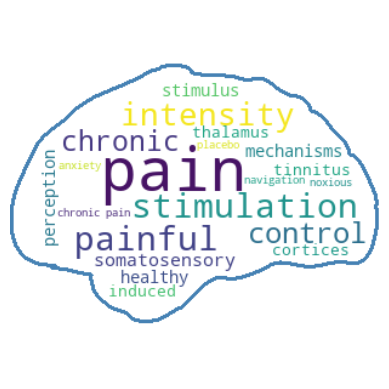

In [226]:
plt.imshow(wc['f2GTf1'],interpolation='bilinear')
plt.axis('off')

In [162]:
words_in_contrast_freq_dict = {}
for contrast in inputs.keys():
    words_in_contrast_freq_dict[contrast] = {}
    for topic in top_topics[contrast].index:
        topic_space      = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
        top_words_series = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:21]
        dsf
        top_words_series = pd.Series(MinMaxScaler().fit_transform(top_words_series.values.reshape(-1,1)).flatten(), index=top_words_series.index)
        #top_words_series = top_words_series/top_words_series.sum()
        for word in top_words_series.index:
            if word in words_in_contrast_freq_dict[contrast]:
                if (top_words_series.loc[word] * this_topic_r) > words_in_contrast_freq_dict[contrast][word]:
                    words_in_contrast_freq_dict[contrast][word] = (top_words_series.loc[word] * this_topic_r)
                #words_in_contrast_freq_dict[contrast][word] = words_in_contrast_freq_dict[contrast][word] + (top_words_series.loc[word] * this_topic_r)
            else:
                words_in_contrast_freq_dict[contrast][word] = top_words_series.loc[word] * this_topic_r
            if word == 'social':
                print(words_in_contrast_freq_dict[contrast][word])

NameError: name 'dsf' is not defined

In [197]:
words_in_contrast_freq_dict['f1GTf2'].sort_values(ascending=False)[0:20]

social          70.0
self            69.0
emotional       68.0
emotion         67.0
negative        66.0
cognitive       65.0
neutral         64.0
positive        63.0
affective       62.0
regulation      61.0
individuals     60.0
empathy         59.0
people          58.0
information     57.0
interactions    56.0
mental          55.0
mind            54.0
moral           53.0
tom             52.0
emotions        51.0
dtype: float64

In [200]:
pd.Series(words_in_contrast_freq_dict['f1GTf2']).sort_values(ascending=False)[0:50]

social                70.0
self                  69.0
emotional             68.0
emotion               67.0
negative              66.0
cognitive             65.0
neutral               64.0
positive              63.0
affective             62.0
regulation            61.0
individuals           60.0
empathy               59.0
people                58.0
information           57.0
interactions          56.0
mental                55.0
mind                  54.0
moral                 53.0
tom                   52.0
emotions              51.0
referential           50.0
control               49.0
independent           48.0
group                 47.0
personality           46.0
faces                 45.0
pictures              44.0
self referential      43.0
valence               42.0
traits                41.0
theory                40.0
mentalizing           39.0
happy                 38.0
trait                 37.0
social cognition      36.0
healthy               35.0
arousal               34.0
e

***

LDA50__42_self_cortex_mpfc
0.3621555588406804
self                2490.899724
empathy              445.080842
mental               377.060627
mind                 373.538500
moral                369.022684
tom                  356.260877
referential          350.001000
personality          339.463922
individuals          323.226700
self referential     306.001000
social               302.999734
positive             300.166285
traits               299.783385
theory               286.995851
cognitive            277.948636
mentalizing          271.187361
people               268.164352
trait                264.488073
information          244.716358
person               241.262604
Name: LDA50__42_self_cortex_mpfc, dtype: float64


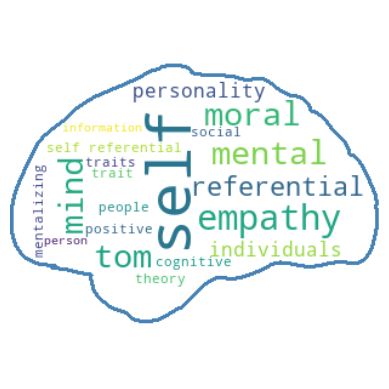

In [168]:
contrast = 'f1GTf2'
topic                 = top_topics[contrast].index[0]
print(topic)
topic_space           = topic.replace('-',' ')
this_topic_r          = top_topics[contrast].loc[topic,DECODING_METRIC]
term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
top_words_series      = term_weigths_in_topic[lda_good_words].sort_values(ascending=False)[0:20]
#top_words_series      = top_words_series/top_words_series.sum()
aux_wc = WordCloud(max_font_size=50, 
                   contour_color='steelblue', contour_width=3,  max_words=20,
                   background_color='white',
                   repeat=False, mask=brain_mask).generate_from_frequencies(top_words_series)
plt.imshow(aux_wc,interpolation='bilinear')
plt.axis('off')
print(this_topic_r)
print(top_words_series)

In [166]:
contrast='f1GTf2'

In [115]:
this_contrast_selected_topics = [topic.replace('-',' ') for topic in top_topics[contrast].index]
this_contrast_p_df            = model.distributions_['p_topic_g_word_df'].loc[this_contrast_selected_topics]
for topic in this_contrast_p_df.index:
    this_topic_r = top_topics[contrast].loc[topic.replace(' ','-'),DECODING_METRIC]
    this_contrast_p_df.loc[topic] = this_topic_r * this_contrast_p_df.loc[topic]
    this_contrast_p_df.loc[topic] = this_contrast_p_df.loc[topic] / this_contrast_p_df.loc[topic].sum()

In [116]:
this_contrast_p_df.sum()[lda_good_words].sort_values(ascending=False)[0:50]

social                0.080743
emotional             0.050175
self                  0.032760
emotion               0.026162
negative              0.024743
neutral               0.017725
cognitive             0.014944
positive              0.014913
affective             0.013058
regulation            0.010877
individuals           0.010111
emotions              0.008930
healthy               0.008913
suggest               0.008758
cognition             0.008214
information           0.008185
interaction           0.007976
group                 0.007941
valence               0.007271
pictures              0.007236
interactions          0.007195
people                0.006987
social cognition      0.006983
faces                 0.006907
control               0.006445
human                 0.006328
behavior              0.006215
correlates            0.005990
empathy               0.005932
mental                0.005829
greater               0.005712
happy                 0.005471
arousal 

In [97]:
(this_contrast_p_df.T/this_contrast_p_df.T.sum()).T.sum().sort_values(ascending=False)[0:75]

social                0.080743
connectivity          0.063583
functional            0.052357
emotional             0.050175
network               0.037152
                        ...   
happy                 0.005471
arousal               0.005468
trait                 0.005382
individual            0.005351
anterior cingulate    0.005177
Length: 75, dtype: float64

In [180]:
pd.Series(words_in_contrast_freq_dict['f2GTf1']).sort_values(ascending=False)[0:50]

familiar         0.016907
navigation       0.015551
time             0.014369
social           0.013098
spatial          0.011032
unfamiliar       0.010844
human            0.009250
virtual          0.008684
mechanisms       0.008443
infant           0.008347
light            0.008296
attachment       0.007866
role             0.007855
route            0.007331
environment      0.006266
evidence         0.006256
game             0.005777
control          0.005703
hippocampus      0.005657
retrosplenial    0.005276
mothers          0.005272
real             0.005215
suggest          0.005199
experience       0.005171
function         0.005080
maternal         0.005072
cooperation      0.005056
rsc              0.005050
effects          0.005025
behavior         0.004960
putamen          0.004916
types            0.004873
mns              0.004844
individuals      0.004778
familiarity      0.004568
behavioral       0.004552
individual       0.004481
partner          0.004405
harm        

LDA50__39_familiar_social_unfamiliar


(-0.5, 304.5, 304.5, -0.5)

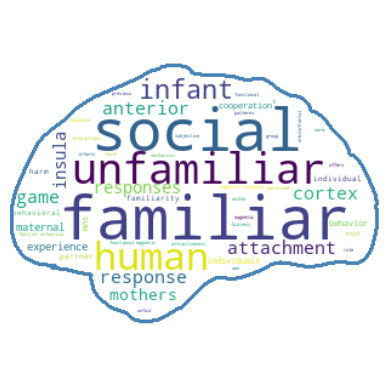

In [195]:
topic                 = top_topics['f2GTf1'].index[1]
print(topic)
topic_space           = topic.replace('-',' ')
this_topic_r          = top_topics[contrast].loc[topic,DECODING_METRIC]
term_weigths_in_topic = model.distributions_['p_topic_g_word_df'].loc[topic_space]
top_words_series      = term_weigths_in_topic.sort_values(ascending=False)[0:50]
#top_words_series      = top_words_series/top_words_series.sum()
aux_wc = WordCloud(max_font_size=50, 
                   contour_color='steelblue', contour_width=3,  max_words=50,
                   background_color='white',
                   repeat=True, mask=brain_mask).generate_from_frequencies(top_words_series)
plt.imshow(aux_wc,interpolation='bilinear')
plt.axis('off')

In [196]:
top_words_series.sort_values(ascending=False)

familiar               307.882036
social                 238.508303
unfamiliar             197.460307
human                  168.439925
infant                 152.001000
response               148.587049
attachment             143.237260
cortex                 127.109406
game                   105.200748
anterior                98.309125
responses               97.838472
insula                  96.288627
mothers                 96.001000
experience              94.154707
maternal                92.365127
cooperation             92.066681
behavior                90.314096
mns                     88.213331
individuals             87.010873
familiarity             83.190624
behavioral              82.899430
individual              81.606171
non                     80.215479
partner                 80.207162
harm                    78.703491
magnetic resonance      76.971085
resonance               76.295358
functional              75.616879
unfair                  75.001000
magnetic      

In [186]:
pd.Series(words_in_contrast_freq_dict['f2GTf1']).sort_values(ascending=False)

gaze                  0.063754
fear                  0.059111
game                  0.054583
response              0.049543
amygdala              0.047417
                        ...   
anxiety depression    0.001901
face                  0.001874
responding            0.001478
shock                 0.001477
heightened            0.001198
Length: 293, dtype: float64

In [161]:
this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
top_topics[contrast]

,pearson,pearson_p,spearman,spearman_p
LDA400__40_gaze_eye_joint,0.183987,0.00137,0.093689,0.105333
LDA400__216_functional_magnetic_magnetic-resonance,0.18106,0.001638,0.191359,0.000864
LDA400__135_fear_extinction_amygdala,0.176216,0.002188,0.18368,0.001397
LDA400__55_correlated_positively_scores,0.168812,0.003359,0.135168,0.019172
LDA400__395_game_playing_video,0.167242,0.003671,0.144542,0.012201
LDA400__384_cortex_systems_frontal,0.15671,0.006532,0.161732,0.004984
LDA400__244_task_response_functional,0.154304,0.007417,0.049913,0.38899
LDA400__370_virtual_navigation_environment,0.152668,0.008078,0.138331,0.016508
LDA400__150_midcingulate_midcingulate-cortex_anterior-midcingulate,0.150311,0.009123,0.056426,0.330044
LDA400__69_kana_high_partners,0.144141,0.012446,0.128319,0.026252


In [145]:
this_topic_weights= {}
wc = {}
for contrast in top_topics.keys():
    this_topic_weights[contrast] = {}
    for topic in top_topics[contrast].index:
        topic_space = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        this_topic_id    = extract_topic_id_from_topic_label(topic)
        this_topic_terms = list(top_term_df[topic_space][::-1].values) 
        for term in this_topic_terms:
            this_term_weight = this_topic_terms.index(term) + 1
            #this_term_weight = topic_g_word_df.loc[topic_space,term]
            if term in this_topic_weights[contrast]:
                this_topic_weights[contrast][term] = this_topic_weights[contrast][term] + (this_topic_r * this_term_weight)
            else:
                this_topic_weights[contrast][term] = this_topic_r * this_term_weight
    this_topic_weights[contrast] = {k:i for k,i in this_topic_weights[contrast].items() if k not in stop_words}
    wc[contrast] = WordCloud(max_font_size=50, 
               contour_color='steelblue', contour_width=3,  max_words=25,
               background_color='white', 
               repeat=True, mask=brain_mask).generate_from_frequencies(this_topic_weights[contrast])

(-0.5, 304.5, 304.5, -0.5)

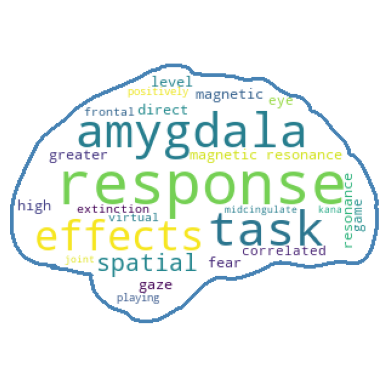

In [151]:
plt.imshow(WordCloud(max_font_size=50, 
               contour_color='steelblue', contour_width=3,  max_words=25,
               background_color='white', 
               repeat=True, mask=brain_mask).fit_words(this_topic_weights[contrast]))
plt.axis('off')

(-0.5, 304.5, 304.5, -0.5)

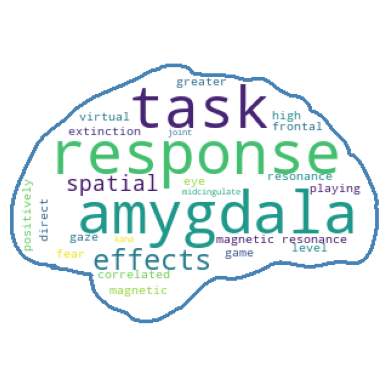

In [152]:
plt.imshow(WordCloud(max_font_size=50, 
               contour_color='steelblue', contour_width=3,  max_words=25,
               background_color='white', 
               repeat=True, mask=brain_mask).generate_from_frequencies(this_topic_weights[contrast]))
plt.axis('off')

In [153]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'alice.txt')).read()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open(path.join(d, "alice_mask.png")))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "alice.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/notebooks/alice.txt'

In [69]:
model.distributions_['p_topic_g_word_df'].loc['LDA400__88_self_mpfc_medial prefrontal'].sort_values(ascending=False)[0:30]

self                   3112.371841
mpfc                    873.500426
medial prefrontal       516.803988
medial                  390.181743
referential             350.001000
personality             317.140292
self referential        306.001000
prefrontal              290.233665
traits                  286.554347
cortex mpfc             267.001000
cortex                  238.533443
prefrontal cortex       237.855305
trait                   235.808721
evaluation              146.338562
personality traits      127.409406
pcc                     125.631922
condition               125.213153
personal                124.304462
processes               121.407364
posterior cingulate     117.524525
midline                 108.662531
involved                106.457632
reported                101.051548
dorsal                   99.517020
judgments                88.956719
functional               87.268862
individuals              85.287850
ventral                  83.026927
self control        

In [49]:
model.distributions_['p_topic_g_word_df'].head(10)

,00,00 00,00 pm,00 reward,00 vs,000,000 hz,000 iu,000 practice,000 registered,...,zone ez,zone involved,zone posterior,zone rcz,zone rcza,zone ventral,zones,zooming,zuckerman,zusanli
LDA400__1_divided_divided attention_attention,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__2_status_mathematical_social status,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__3_rcbf_flow rcbf_regional cerebral,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__4_vestibular_dominance_cortical,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__5_cortical_cortex_response,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__6_speech_production_acoustic,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__7_youth_abeta_amyloid,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__8_equation_structural_structural equation,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__9_postpartum_recency_recency judgments,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
LDA400__10_cocaine_dependence_cd,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [50]:
%time
n_top_terms = 10 # 20 is what's available in NeuroSynth
top_term_df = model.distributions_["p_topic_g_word_df"].T
temp_df = top_term_df.copy()
top_term_df = pd.DataFrame(columns=top_term_df.columns, index=range(n_top_terms))
top_term_df.index.name = "Token"
for col in top_term_df.columns:
    top_tokens = temp_df.sort_values(by=col, ascending=False).index.tolist()[:n_top_terms]
    top_term_df.loc[:, col] = top_tokens

top_term_df.head(3)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


,LDA400__1_divided_divided attention_attention,LDA400__2_status_mathematical_social status,LDA400__3_rcbf_flow rcbf_regional cerebral,LDA400__4_vestibular_dominance_cortical,LDA400__5_cortical_cortex_response,LDA400__6_speech_production_acoustic,LDA400__7_youth_abeta_amyloid,LDA400__8_equation_structural_structural equation,LDA400__9_postpartum_recency_recency judgments,LDA400__10_cocaine_dependence_cd,...,LDA400__391_cortex_reho_receiver,LDA400__392_time_series_expertise,LDA400__393_dentate_olds_year olds,LDA400__394_rtms_repetitive_repetitive transcranial,LDA400__395_game_playing_video,LDA400__396_gyrus_parahippocampal_guilt,LDA400__397_networks_motor imagery_functional,LDA400__398_sleep_deprivation_sleep deprivation,LDA400__399_responses_ccs_cortex,LDA400__400_math_performance_cognitive
Token,,,,,,,,,,,,,,,,,,,,,
0,divided,status,rcbf,vestibular,cortical,speech,youth,equation,postpartum,cocaine,...,cortex,time,dentate,rtms,game,gyrus,networks,sleep,responses,math
1,divided attention,mathematical,flow rcbf,dominance,cortex,production,abeta,structural,recency,dependence,...,reho,series,olds,repetitive,playing,parahippocampal,motor imagery,deprivation,ccs,performance
2,attention,social status,regional cerebral,cortical,response,acoustic,amyloid,structural equation,recency judgments,cd,...,receiver,expertise,year olds,repetitive transcranial,video,guilt,functional,sleep deprivation,cortex,cognitive


In [52]:
stop_words = ["functional","using","bold","level","state","connectivity","functional connectivity","blood","network","cortex","magnetic","anterior","medial","fc",'reho'] + list(STOPWORDS)

In [57]:
#topic_g_word_df = model.distributions_['p_topic_g_word_df']/model.distributions_['p_topic_g_word_df'].sum(axis=0)
topic_g_word_df =(model.distributions_['p_topic_g_word_df'].T/model.distributions_['p_topic_g_word_df'].sum(axis=1)).T

In [58]:
this_topic_weights= {}
wc = {}
for contrast in top_topics.keys():
    this_topic_weights[contrast] = {}
    for topic in top_topics[contrast].index:
        topic_space = topic.replace('-',' ')
        this_topic_r     = top_topics[contrast].loc[topic,DECODING_METRIC]
        this_topic_id    = extract_topic_id_from_topic_label(topic)
        this_topic_terms = list(top_term_df[topic_space][::-1].values) 
        for term in this_topic_terms:
            this_term_weight = this_topic_terms.index(term) + 1
            #this_term_weight = topic_g_word_df.loc[topic_space,term]
            if term in this_topic_weights[contrast]:
                this_topic_weights[contrast][term] = this_topic_weights[contrast][term] + (this_topic_r * this_term_weight)
            else:
                this_topic_weights[contrast][term] = this_topic_r * this_term_weight
    this_topic_weights[contrast] = {k:i for k,i in this_topic_weights[contrast].items() if k not in stop_words}
    wc[contrast] = WordCloud(max_font_size=50, 
               contour_color='steelblue', contour_width=3,  max_words=25,
               background_color='white', 
               repeat=True, mask=brain_mask).fit_words(this_topic_weights[contrast])

(-0.5, 304.5, 304.5, -0.5)

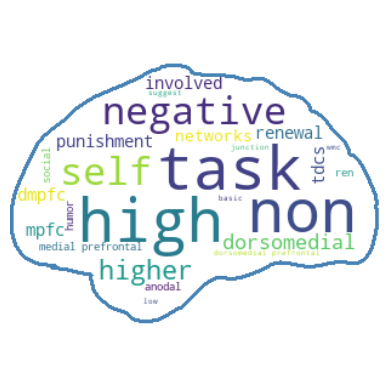

In [59]:
plt.imshow(wc['f1GTf2'],interpolation='bilinear')
plt.axis('off')

(-0.5, 304.5, 304.5, -0.5)

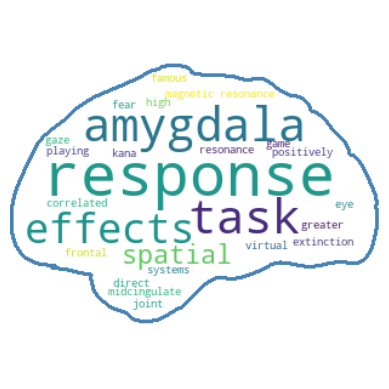

In [60]:
plt.imshow(wc['f2GTf1'],interpolation='bilinear')
plt.axis('off')

In [58]:
top_topics

{'f1GTf2':                                                            r
 LDA400__343_tdcs_anodal_sham                        0.234431
 LDA400__331_stroke_moral_recovery                   0.232843
 LDA400__88_self_mpfc_medial-prefrontal              0.228669
 LDA400__259_connectivity_functional_functional-...  0.228572
 LDA400__319_negative_positive_correlation           0.212238,
 'f2GTf1':                                                    r
 LDA400__370_virtual_navigation_environment  0.321982
 LDA400__365_visual_cortex_visual-cortex     0.250600
 LDA400__40_gaze_eye_joint                   0.246312
 LDA400__198_group_using_ot                  0.198733
 LDA400__4_vestibular_dominance_cortical     0.198017}

In [12]:
import os

import pandas as pd

from nimare import annotate
from nimare.dataset import Dataset
from nimare.utils import get_resource_path

In [13]:
dset = Dataset.load('/data/SFIMJGC_Introspec/prj2021_dyneusr/Resources_NiMare/LDA50/neurosynth_dataset.pkl.gz')

In [14]:
model = annotate.lda.LDAModel(n_topics=5, max_iter=1000, text_column="abstract")

In [15]:
new_dset = model.fit(dset)

ValueError: Column 'abstract' not found in DataFrame

In [9]:
model.distributions_["p_topic_g_word_df"].T

,LDA5__1_human_functional_maps,LDA5__2_social_connectivity_functional,LDA5__3_connectivity_functional_macm,LDA5__4_connectivity_posterior_functional,LDA5__5_motor_frontal_cortex
10,1.000970,0.00100,0.001000,0.001000,1.001030
abstract,0.001000,2.00100,0.001000,0.001000,0.001000
action,1.001226,0.00100,1.000774,0.001000,0.001000
active,0.001000,0.00100,1.000711,3.001289,0.001000
addition,1.001049,1.00124,1.000528,2.001183,0.001000
...,...,...,...,...,...
ventromedial,0.001000,0.00100,0.001000,1.000060,2.001940
voxel,1.001243,0.00100,1.000322,1.000912,1.001523
voxel morphometry,0.001000,0.00100,1.000917,1.001083,0.001000
working,1.001151,0.00100,1.000849,0.001000,0.001000


In [10]:
os.path.join(get_resource_path(), "neurosynth_laird_studies.json")

'/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection/lib/python3.7/site-packages/nimare/resources/neurosynth_laird_studies.json'

In [19]:
dset.ids.shape

(14371,)

In [29]:
from nimare.extract import download_abstracts
abstracts = download_abstracts(list(dset.ids),'javiergc@mail.nih.gov')

INFO:nimare.extract.extract:Downloading chunk 1 of 16
INFO:nimare.extract.extract:Downloading chunk 2 of 16
INFO:nimare.extract.extract:Downloading chunk 3 of 16
INFO:nimare.extract.extract:Downloading chunk 4 of 16
INFO:nimare.extract.extract:Downloading chunk 5 of 16
INFO:nimare.extract.extract:Downloading chunk 6 of 16
INFO:nimare.extract.extract:Downloading chunk 7 of 16
INFO:nimare.extract.extract:Downloading chunk 8 of 16
INFO:nimare.extract.extract:Downloading chunk 9 of 16
INFO:nimare.extract.extract:Downloading chunk 10 of 16
INFO:nimare.extract.extract:Downloading chunk 11 of 16
INFO:nimare.extract.extract:Downloading chunk 12 of 16
INFO:nimare.extract.extract:Downloading chunk 13 of 16
INFO:nimare.extract.extract:Downloading chunk 14 of 16
INFO:nimare.extract.extract:Downloading chunk 15 of 16
INFO:nimare.extract.extract:Downloading chunk 16 of 16


In [38]:
abstracts['id'] = abstracts['study_id']+'-1'

In [40]:
abstracts['constrast_id'] = 1

In [41]:
dset.texts = abstracts

In [42]:
model = annotate.lda.LDAModel(n_topics=50, max_iter=1000, text_column="abstract")

In [47]:
new_dset = model.fit(dset)

In [ ]:
dset         = Dataset.load('/data/SFIMJGC_Introspec/prj2021_dyneusr/Resources_NiMare/LDA400/neurosynth_dataset.pkl.gz')
dset.texts   = abstracts

In [ ]:
model_400    = annotate.lda.LDAModel(n_topics=400, max_iter=1000, text_column="abstract")

In [ ]:
new_dset_400 = model_400.fit(dset)

In [33]:
laird_dset = Dataset(os.path.join(get_resource_path(), "neurosynth_laird_studies.json"))

In [35]:
laird_dset.texts

,id,study_id,contrast_id,abstract
0,17029760-1,17029760,1,Repetitive transcranial magnetic stimulation (...
1,18760263-1,18760263,1,In an effort to clarify how deductive reasonin...
2,19162389-1,19162389,1,A sizable literature on the neuroimaging of sp...
3,19603407-1,19603407,1,Functional neuroimaging has evolved into an in...
4,20197097-1,20197097,1,Spatial normalization of neuroimaging data is ...
5,22569543-1,22569543,1,Neuro-imaging methods for detecting functional...
6,22659444-1,22659444,1,Spinocerebellar ataxia type 17 (SCA17) is a ra...
7,23042731-1,23042731,1,The orbitofrontal cortex (OFC) is implicated i...
8,23702412-1,23702412,1,The frontal pole has more expanded than any ot...
9,24681401-1,24681401,1,Voice control is critical to communication. To...


In [44]:
dset.get_texts()

['abstract', 'constrast_id']

In [45]:
laird_dset.get_texts()

['abstract']

In [46]:
laird_dset.texts

,id,study_id,contrast_id,abstract
0,17029760-1,17029760,1,Repetitive transcranial magnetic stimulation (...
1,18760263-1,18760263,1,In an effort to clarify how deductive reasonin...
2,19162389-1,19162389,1,A sizable literature on the neuroimaging of sp...
3,19603407-1,19603407,1,Functional neuroimaging has evolved into an in...
4,20197097-1,20197097,1,Spatial normalization of neuroimaging data is ...
5,22569543-1,22569543,1,Neuro-imaging methods for detecting functional...
6,22659444-1,22659444,1,Spinocerebellar ataxia type 17 (SCA17) is a ra...
7,23042731-1,23042731,1,The orbitofrontal cortex (OFC) is implicated i...
8,23702412-1,23702412,1,The frontal pole has more expanded than any ot...
9,24681401-1,24681401,1,Voice control is critical to communication. To...
